# Prithvi WxC ECCC Downscaling: Model Fine Tuning and Inference using TerraTorch

This notebook is a walk through to use a downscaling model to generate inferences using TerraTorch with the ECCC data

We show how to initalize the model, load weights, and use the model for inference using TerraTorch

**TODO: add SETUP ENVIRONMENT**

In [1]:
import logging
import warnings
logging.disable(logging.CRITICAL)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import numpy as np
import terratorch   # this import is needed to initialize TT's factories

from lightning.pytorch import Trainer
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint

from terratorch.models.wxc_model_factory import WxCModelFactory
from terratorch.tasks.eccc_downscaling_task import ECCCTask, CheckpointCallback
from terratorch.datamodules.eccc import ECCCDataModule

from granitewxc.utils.config import get_config
from eccc_downscaling.utils.plot import plot_sample, plot_model_results, plot_residual_and_power_spectrum

/u/victornasc/.conda/envs/prithvi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ECCC Downscaling Task

The `ECCCTask` class is task module designed to manage the training, validation, and testing processes for models built on the ECCC data

It extends the functionality of `BaseTask` in the Terratorch framework and encapsules the logic for model creation, optimization, and evaluation


We provide a configuration file to define data variables and model parameters.

This includes the variables used for model training, the variables to be downscaled, the number of input timesteps, the downscaling factor, the model's dimensions, ....


In [3]:
config = get_config('./examples/confs/eccc_downscaling_unet.yaml')
task = ECCCTask(WxCModelFactory(), model_args=config)

Creating the model.
--> model has 254,648,712 params.
Loading pre-trained model weights ./experiments/pretrained/prithvi.wxc.2300m.v1.pt...


# Datamodule

A datamodule is a self-contained module that organizes and manages the preparation of training, validation, and test datasets, along with any associated data transformations

We have built a datamodule for the ECCC data

In [4]:
datamodule = ECCCDataModule(config)

### Example of the data

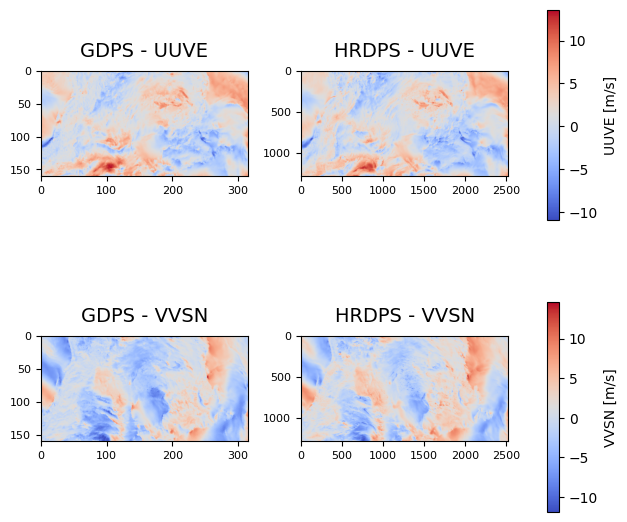

In [8]:
datamodule.setup(stage='predict')
pred_dl = datamodule.predict_dataloader()
plot_sample(next(iter(pred_dl)))

# Training

Pytorch Lightning trainers are high-level abstractions that encapsulate the model, loss function, optimizer, and training hyperparameters

They build on the model factory we introduced previously and are able to take any. To use a task with a model not supported by a currently existing model factory, simply create your own model factory!

Let's create a Trainer

In [9]:
logger = TensorBoardLogger("logs", name="eccc", log_graph=False)
checkpoint_callback = CheckpointCallback(config, save_every_n_epochs=1)

trainer = Trainer(
    max_epochs=5,
    check_val_every_n_epoch=1,
    log_every_n_steps = config.data.n_random_windows,
    logger=logger,
    callbacks=[checkpoint_callback],
    devices=1,
    precision="16-mixed",
)

In [10]:
datamodule.setup(stage='train')
datamodule.setup(stage='val')
trainer.fit(model=task, datamodule=datamodule)

Epoch 0: 100%|████████████████████████████████████████████████████| 16/16 [00:03<00:00,  5.14it/s, v_num=0]
--> Saved checkpoint: ./experiments/pretrained/checkpoint_0.pt
Epoch 1: 100%|████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.60it/s, v_num=0]
--> Saved checkpoint: ./experiments/pretrained/checkpoint_1.pt
Epoch 2: 100%|████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.79it/s, v_num=0]
--> Saved checkpoint: ./experiments/pretrained/checkpoint_2.pt
Epoch 3: 100%|████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.59it/s, v_num=0]
--> Saved checkpoint: ./experiments/pretrained/checkpoint_3.pt
Epoch 4: 100%|████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.54it/s, v_num=0]
--> Saved checkpoint: ./experiments/pretrained/checkpoint_4.pt
Epoch 4: 100%|████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s, v_num=0]


##### Analyze training in tensorboard

In [11]:
# !tensorboard --logdir logs/ --port 9010  # add --host $(hostname -f) for clusters

### Evaluation on the test set

In [12]:
datamodule.setup(stage='test')
test_metrics = trainer.test(model=task, datamodule=datamodule)

Testing DataLoader 0: 100%|██████████████████████████████████████████████████| 1/1 [00:03<00:00,  0.27it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_LSD          │    0.2996216416358948     │
│         test_MAE          │    0.7138205766677856     │
│        test_MSSIM         │    0.7372913956642151     │
│         test_loss         │    1.0413849353790283     │
└───────────────────────────┴───────────────────────────┘

# Prediction

In [13]:
datamodule.setup(stage='predict')
results = trainer.predict(model=task, datamodule=datamodule, return_predictions=True)

Predicting DataLoader 0: 100%|███████████████████████████████████████████████| 1/1 [00:03<00:00,  0.28it/s]


In [14]:
idx = 0 # select a sample
pred_dl = datamodule.predict_dataloader()
batch = next(iter(pred_dl))

inputs = batch["x"][idx].cpu().numpy()
targets = batch["y"][idx].cpu().numpy()
result = results[idx].output.squeeze().cpu().numpy()
residuals = targets - result

In [15]:
print(f"Input shape:  {inputs.shape}")
print(f"Target shape: {targets.shape}")
print(f"Result shape: {result.shape}")

Input shape:  (57, 160, 316)
Target shape: (2, 1280, 2528)
Result shape: (2, 1280, 2528)


### Plotting 

In [16]:
from itertools import product

# getting variable indexes
output_vars = [*config.data.output_vars]
input_vars = [*config.data.input_surface_vars, 
              *product(config.data.vertical_pres_vars, config.data.input_level_pres),
              *product(config.data.vertical_level1_vars, config.data.input_level1 ),
              *product(config.data.vertical_level2_vars, config.data.input_level2),
              *config.data.other
             ]

coarsening_factor = targets.shape[-1] / inputs.shape[-1] 

var_name = "UUWE" # UUWE or VVSN
var_unit = "m/s" 
f"Downscaling '{var_name}' at  by {coarsening_factor}x"

"Downscaling 'UUWE' at  by 8.0x"

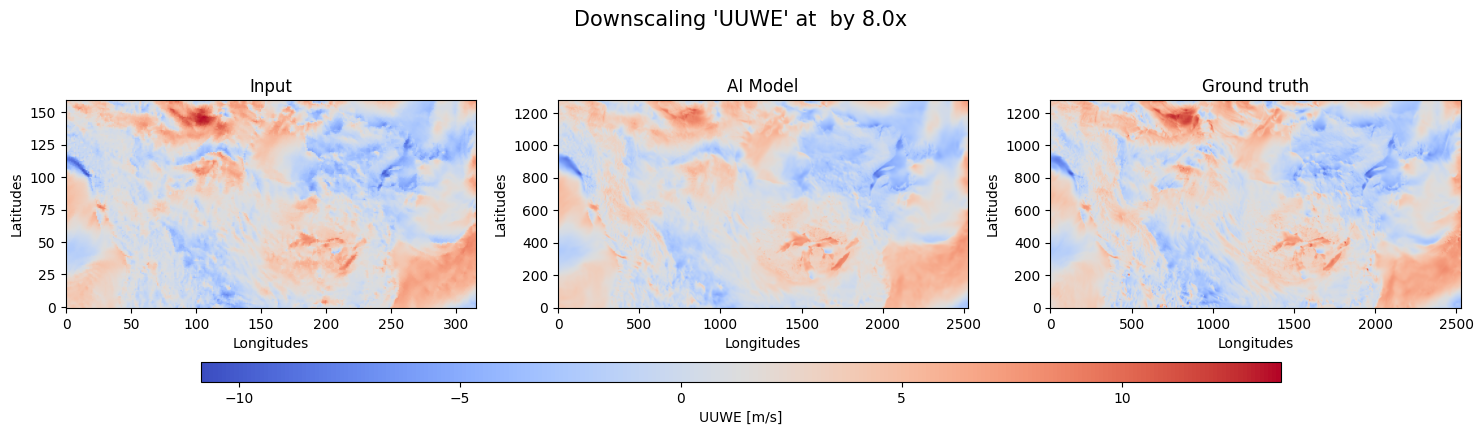

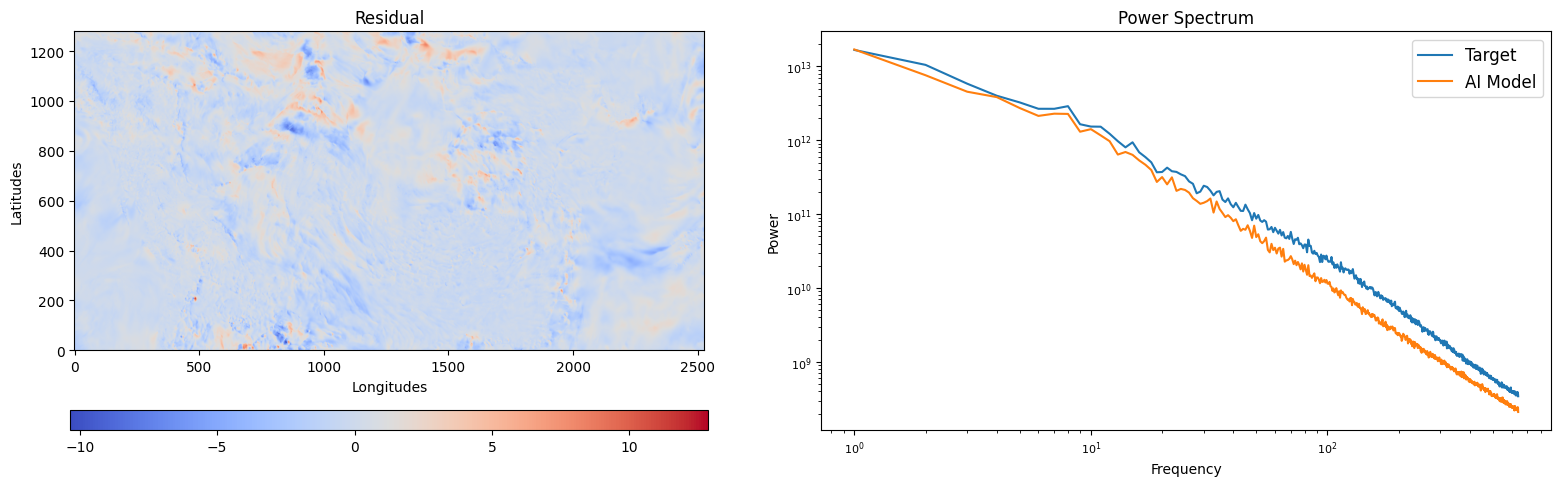

In [17]:
output_var = output_vars.index(var_name)
input_var = input_vars.index(var_name)

plot_val_kwargs = dict(
    cmap='coolwarm',
    vmin = min(np.min(inputs[input_var]), np.min(targets[output_var]), np.min(result[output_var])),
    vmax = max(np.max(inputs[input_var]), np.max(targets[output_var]), np.max(result[output_var])),
    var_name_title=var_name,
    var_unit=var_unit
    )

plot_model_results(
    [inputs[1], result[0], targets[0]],
    ['Input', 'AI Model', 'Ground truth'],
    title=f"Downscaling '{var_name}' at  by {coarsening_factor}x",
    cbar_title=f"{var_name} [{var_unit}]",
    **plot_val_kwargs
)

plot_residual_and_power_spectrum(residuals[output_var], targets[output_var], result[output_var], kwargs={'vmin': -2, 'vmax': 2})